In [1]:
import numpy as np

import matplotlib.pyplot as plt
from dwichd.io import load_mrtrix, save_mrtrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess
import os
from matplotlib.colors import PowerNorm
import utils

In [2]:
DATA_DIR = f'/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/'
PREPROC_DIR = f'/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/'
SAVE_DIR = f'/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/Blind_Deconvolution/temp/'
MTCSD_DIR = f'/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/'

In [3]:
def mask2edge(binary_mask):
    if len(binary_mask.shape) == 2:
        gx, gy, = np.gradient(binary_mask.astype(float))
        edge = gy * gy + gx * gx
    elif len(binary_mask.shape) == 3:
        gx, gy, gz = np.gradient(binary_mask.astype(float))
        edge = gy * gy + gx * gx + gz * gz
    else:
        raise Exception
    edge[edge != 0] = 1
    return edge

def find_preproc_subdirectories(root_directory):
    """
    Finds all subdirectories containing a directory named "PREPROC".

    Args:
        root_directory (str): The path to the root directory.

    Returns:
        list: A list of subdirectories containing "PREPROC".
    """
    preproc_subdirectories = []
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if "PREPROC" in dirnames:
            preproc_subdirectories.append(dirpath)
    return preproc_subdirectories


In [4]:
angular_correlations = []
bd_residuals = []
csd_redisuals = []

In [5]:
healthy_datasets = [os.path.join(DATA_DIR, f) for f in ['philips']]
glioma_datasets = [f for f in find_preproc_subdirectories(DATA_DIR) if 'glioma' in f and 'sub-PT021' not in f]
# glioma_datasets = [f for f in find_preproc_subdirectories(DATA_DIR) if 'glioma' in f]
datasets = np.asarray(healthy_datasets + glioma_datasets)
print(datasets)

['/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/philips'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT066'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT068'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT010'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT070'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT001'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT009'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT012'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT002'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT015'
 '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT006']


In [6]:
brain_slices = {
    'philips': (35, 'Healthy'),
    '3shell': (22, 'Healthy'),
    'new_protocol': (24, 'Healthy'),
    'sub-PT001': (34, 'Low Grade'),
    'sub-PT002': (35, 'High Grade'),
    'sub-PT006': (40, 'High Grade'),
    'sub-PT009': (48, 'High Grade'),
    'sub-PT010': (35, 'Low Grade'),
    'sub-PT012': (31, 'High Grade'),
    'sub-PT015': (34, 'Low Grade'),
    'sub-PT021': (41, 'High Grade'),
    'sub-PT066': (45, 'Low Grade'),
    'sub-PT068': (43, 'High Grade'),
    'sub-PT070': (33, 'Low Grade'),
}

In [7]:
def regrid_lesion(dwi_path, lesion_path, out_path):
    temp_dir = '/LOCALDATA/sleyse4'
    subprocess.run(['dwiextract', f'{dwi_path}', '-bzero', f'{temp_dir}/mean_b0.mif'])
    subprocess.run(
        ['mrgrid', f'{lesion_path}', 'regrid', '-template', f'{temp_dir}/mean_b0.mif', f'{out_path}', '-force'])
    subprocess.run(['rm', f'{temp_dir}/mean_b0.mif'])


def normalise_residuals(res_bsd, res_csd, mask):
    minn = min(np.amin(res_bsd[mask]), np.amin(res_csd[mask]))
    maxx = max(np.amax(res_bsd[mask]), np.amax(res_csd[mask]))
    return (res_bsd - minn) / (maxx - minn), (res_csd - minn) / (maxx - minn)


def get_stats_in_mask(data, lesion_mask):
    return np.mean(data[lesion_mask]), np.std(data[lesion_mask])


def pad_to_shape(data, shape):
    data_shape = data.shape

    pad_x = shape[0] - data_shape[0]
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    pad_y = shape[1] - data_shape[1]
    pad_bottom = pad_y // 2
    pad_top = pad_y - pad_bottom

    return np.pad(data, ((pad_left, pad_right), (pad_bottom, pad_top)))

def clean_axis(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def add_colorbar(im, ax, ticksize, visible=True, ticks=None, ticklabels=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', size='5%', pad=.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=ticksize)
    if not visible:
        cbar.ax.set_visible(False)
    if ticks is not None:
        cbar.ax.set_yticks([float(t) for t in ticks])
        if ticklabels is not None:
            cbar.ax.set_yticklabels(ticklabels)
        else:
            cbar.ax.set_yticklabels(ticks)

def clip(img, mask):
    mask_x = np.unique(np.where(mask)[0])
    mask_y = np.unique(np.where(mask)[1])
    x_min, x_max = np.min(mask_x), np.max(mask_x)
    y_min, y_max = np.min(mask_y), np.max(mask_y)
    return img[x_min:x_max+1, y_min:y_max+1]

In [8]:
def overlay_lesion(lesion, mask, output_shape, ax):
    lesion_edge = clip(mask2edge(lesion), mask)
    lesion_edge = pad_to_shape(lesion_edge, output_shape)
    ax.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')

In [9]:
# import Rank1
# for dataset in datasets:
#     if '021' not in dataset:
#         subject = dataset.split('/')[-1]
#         normed = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'normed.mif'))
#         mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5
#         vox = normed.vox
#         normed_dwi = normed.data
#         pred_mtcsd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/predicted_signal.mif')).data
#         residual_mtcsd = Rank1.residual(pred_mtcsd, normed_dwi, mask)
#         save_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/residual.mif'), Image(data=residual_mtcsd, vox=vox, comments=['Residuals MSMT-CSD']))

## Residuals for all datasets

## In vivo ACC

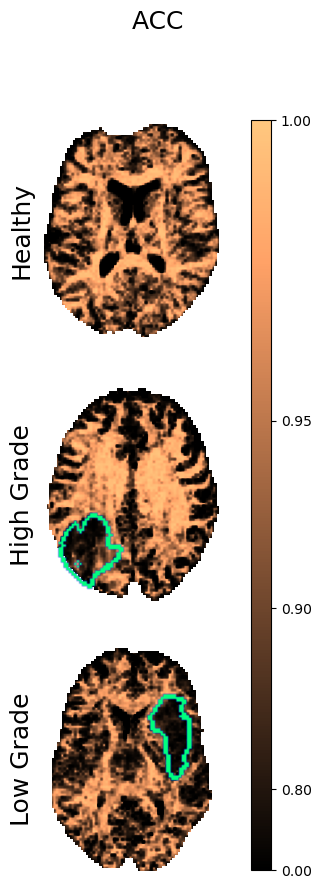

In [10]:
fig = plt.figure(figsize=(5, 10))
gs = fig.add_gridspec(nrows=3, ncols=1, wspace=0, hspace=0)

titles = datasets

sub_datasets = list(filter(lambda f: 'philips' in f or 'PT068' in f or 'PT070' in f,datasets))

gs_acc = fig.add_gridspec(ncols=1, nrows=len(sub_datasets), hspace=0.1, wspace=0)

sub_masks = [load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5 for \
         dataset in sub_datasets]

mask_shapes = [clip(m, m).shape for m in sub_masks]
out_shape = (np.max([m[0] for m in mask_shapes]), np.max([m[1] for m in mask_shapes]))

for i, dataset in enumerate(sub_datasets):
    # Add a column
    ax = fig.add_subplot(gs_acc[i,0])

    subject = dataset.split('/')[-1]
    slice, grade = brain_slices[subject]

    # Load the data
    acc = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'acc.mif')).data[:,:,slice]
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data[:,:,slice] > .5

    # Clip and mask the data
    acc = pad_to_shape(clip(acc, mask), out_shape)
    # mask = pad_to_shape(clip(mask, mask), out_shape)
    acc = np.ma.masked_where(acc==0, acc)

    # Plot the data
    im = ax.imshow(np.rot90(acc), interpolation=None, cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=10))

    # If glioma, overlay with glioma outline
    if 'glioma' in dataset:
        lesion = load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data[:,:,slice] > .5
        overlay_lesion(lesion, mask, out_shape, ax)

    # Clean axis from ticks and labels
    clean_axis(ax)
    ax.set_ylabel(grade, fontsize=18)

# Add a colorbar
cax = plt.axes([0.75, 0.12, 0.04, 0.75])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_yticks([0, 0.8, 0.9, 0.95, 1])
# cbar.ax.set_yticklabels(['0', '0.8', '0.9', '0.95', '1'])

plt.suptitle('        ACC', fontsize=18)

plt.savefig('images/in_vivo_ACC.png', dpi=300, transparent=True)
plt.show()

## In vivo data loss

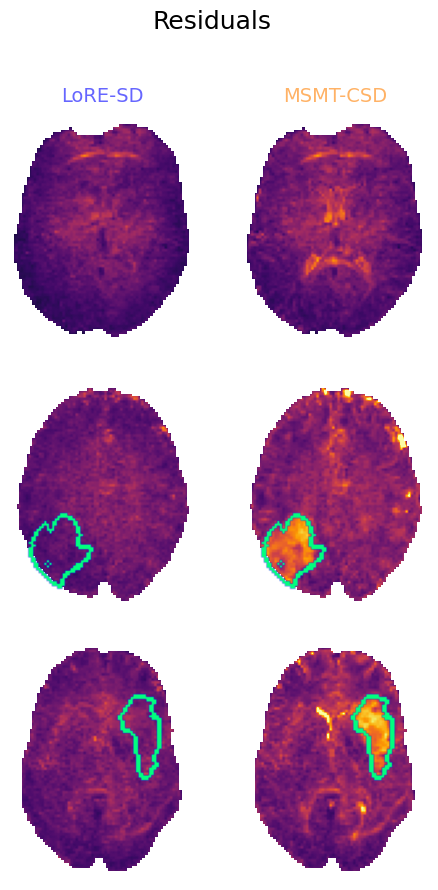

In [11]:
fig = plt.figure(figsize=(6, 10))

titles = datasets

sub_datasets = list(filter(lambda f: 'philips' in f or 'PT068' in f or 'PT070' in f,datasets))

gs_res = fig.add_gridspec(ncols=2, nrows=len(sub_datasets), hspace=0.1, wspace=0)

sub_masks = [load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5 for \
         dataset in sub_datasets]

mask_shapes = [clip(m, m).shape for m in sub_masks]
out_shape = (np.max([m[0] for m in mask_shapes]), np.max([m[1] for m in mask_shapes]))

for i, dataset in enumerate(sub_datasets):
    # Add a column
    ax_lore = fig.add_subplot(gs_res[i,0])
    ax_csd = fig.add_subplot(gs_res[i,1])

    subject = dataset.split('/')[-1]
    slice, grade = brain_slices[subject]

    # Load the data
    res_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'residual.mif')).data[:,:,slice]
    res_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/residual.mif')).data[:,:,slice]
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data[:,:,slice] > .5

    # Clip and mask the data
    res_lore = pad_to_shape(clip(res_lore, mask), out_shape)
    res_csd = pad_to_shape(clip(res_csd, mask), out_shape)
    res_lore = np.ma.masked_where(res_lore==0, res_lore)
    res_csd = np.ma.masked_where(res_csd==0, res_csd)

    vmin = 0
    vmax = 100

    # Plot the data
    im_lore = ax_lore.imshow(np.rot90(res_lore), interpolation=None, cmap='inferno', vmin=vmin, vmax=vmax)
    im_csd = ax_csd.imshow(np.rot90(res_csd), interpolation=None, cmap='inferno', vmin=vmin, vmax=vmax)

    # If glioma, overlay with glioma outline
    if 'glioma' in dataset:
        lesion = load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data[:,:,slice] > .5
        overlay_lesion(lesion, mask, out_shape, ax_lore)
        overlay_lesion(lesion, mask, out_shape, ax_csd)

    # Clean axis from ticks and labels
    clean_axis(ax_lore)
    clean_axis(ax_csd)

    if i == 0:
        ax_lore.set_title('LoRE-SD', fontsize=14, color=(0,0,1,.6))
        ax_csd.set_title('MSMT-CSD', fontsize=14, color=(1,.5,0,.6))

# Add a colorbar
# cax = plt.axes([.9, 0.12, 0.04, 0.75])
# cbar = plt.colorbar(im_lore, cax=cax)
# cbar.ax.set_yticks([0, 0.8, 0.9, 0.95, 1])

plt.suptitle('Residuals', fontsize=18)

plt.savefig('images/in_vivo_data_loss.png', dpi=300, transparent=True)
plt.show()

## In vivo AIC

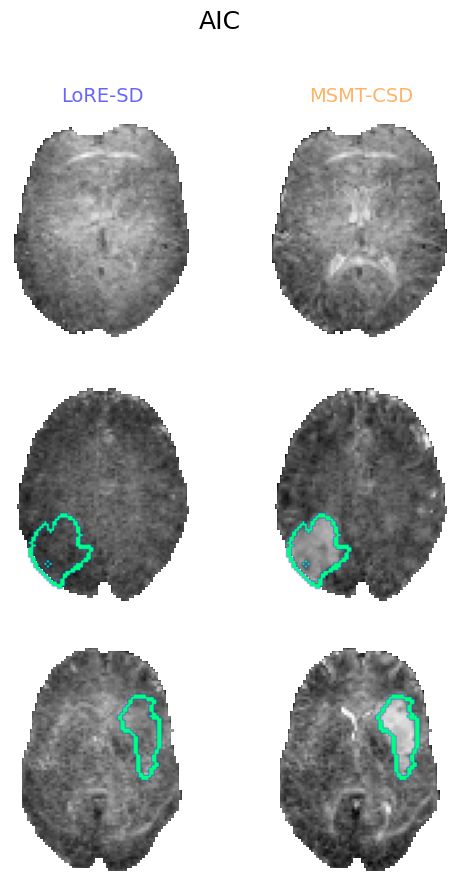

In [12]:
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(10, 10))

titles = datasets

sub_datasets = list(filter(lambda f: 'philips' in f or 'PT068' in f or 'PT070' in f,datasets))

gs_res = fig.add_gridspec(ncols=2, nrows=len(sub_datasets), hspace=0.1, wspace=-.5)

sub_masks = [load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5 for \
         dataset in sub_datasets]

mask_shapes = [clip(m, m).shape for m in sub_masks]
out_shape = (np.max([m[0] for m in mask_shapes]), np.max([m[1] for m in mask_shapes]))

for i, dataset in enumerate(sub_datasets):
    # Add a column
    ax_lore = fig.add_subplot(gs_res[i,0])
    ax_csd = fig.add_subplot(gs_res[i,1])
    subject = dataset.split('/')[-1]
    slice, grade = brain_slices[subject]

    # Load the data
    aic_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'AIC.mif')).data[:,:,slice]
    aic_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/AIC.mif')).data[:,:,slice]
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data[:,:,slice] > .5

    # Clip and mask the data
    aic_lore = pad_to_shape(clip(aic_lore, mask), out_shape)
    aic_csd = pad_to_shape(clip(aic_csd, mask), out_shape)
    aic_lore = np.ma.masked_where(aic_lore==0, aic_lore)
    aic_csd = np.ma.masked_where(aic_csd==0, aic_csd)

    vmin = np.min([np.min(aic_lore), np.min(aic_csd)])
    vmax = np.max([np.max(aic_lore), np.max(aic_csd)])

    # Plot the data
    im_lore = ax_lore.imshow(np.rot90(aic_lore), interpolation=None, cmap='grey', vmin=vmin, vmax=vmax)
    im_csd = ax_csd.imshow(np.rot90(aic_csd), interpolation=None, cmap='grey', vmin=vmin, vmax=vmax)

    # If glioma, overlay with glioma outline
    if 'glioma' in dataset:
        lesion = load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data[:,:,slice] > .5
        overlay_lesion(lesion, mask, out_shape, ax_lore)
        overlay_lesion(lesion, mask, out_shape, ax_csd)

    # Clean axis from ticks and labels
    clean_axis(ax_lore)
    clean_axis(ax_csd)

    if i == 0:
        ax_lore.set_title('LoRE-SD', fontsize=14, color=(0,0,1,.6))
        ax_csd.set_title('MSMT-CSD', fontsize=14, color=(1,.5,0,.6))


plt.suptitle('AIC', fontsize=18)

plt.savefig('images/in_vivo_aic.png', dpi=300, transparent=True)
plt.show()

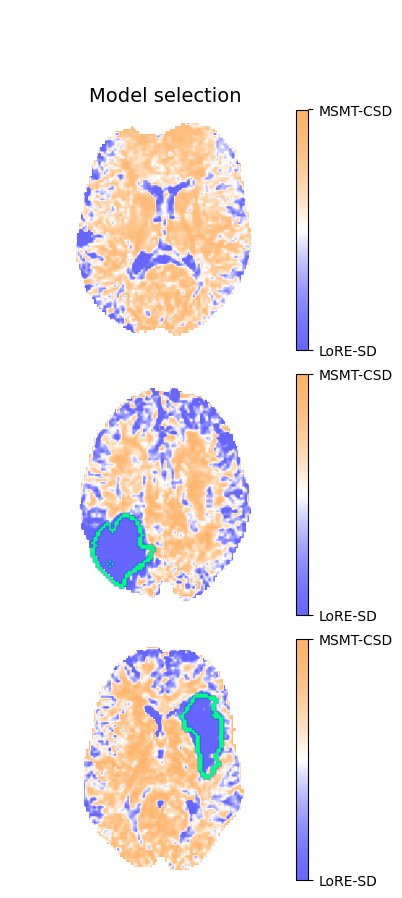

In [13]:
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(10, 10))

aic_diff_cmap = LinearSegmentedColormap.from_list('AIC_Gradient_CMap', (
    (0.000, (0, 0, 1, .6)),
    (0.500, (1, 1, 1, 1)),
    (1.000, (1, .5, 0, .6))))

titles = datasets

sub_datasets = list(filter(lambda f: 'philips' in f or 'PT068' in f or 'PT070' in f,datasets))

gs_res = fig.add_gridspec(ncols=1, nrows=len(sub_datasets), hspace=0.1, wspace=-.5)

sub_masks = [load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5 for \
         dataset in sub_datasets]

mask_shapes = [clip(m, m).shape for m in sub_masks]
out_shape = (np.max([m[0] for m in mask_shapes]), np.max([m[1] for m in mask_shapes]))

for i, dataset in enumerate(sub_datasets):
    # Add a column
    ax_model = fig.add_subplot(gs_res[i,0])

    subject = dataset.split('/')[-1]
    slice, grade = brain_slices[subject]

    # Load the data
    aic_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'AIC.mif')).data[:,:,slice]
    aic_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/AIC.mif')).data[:,:,slice]
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data[:,:,slice] > .5

    # Clip and mask the data
    aic_lore = pad_to_shape(clip(aic_lore, mask), out_shape)
    aic_csd = pad_to_shape(clip(aic_csd, mask), out_shape)
    aic_lore = np.ma.masked_where(aic_lore==0, aic_lore)
    aic_csd = np.ma.masked_where(aic_csd==0, aic_csd)

    aic_model = np.asarray(aic_lore - aic_csd)
    aic_model = np.ma.masked_where(aic_csd==0, aic_model)
    vmin_model = -np.max([np.min(aic_model), np.max(aic_model)])
    vmax_model = -vmin_model

    # Plot the data
    im_model = ax_model.imshow(np.rot90(aic_model), interpolation=None, cmap=aic_diff_cmap, vmin=vmin_model, vmax=vmax_model)

    # If glioma, overlay with glioma outline
    if 'glioma' in dataset:
        lesion = load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data[:,:,slice] > .5
        overlay_lesion(lesion, mask, out_shape, ax_model)

    # Clean axis from ticks and labels
    clean_axis(ax_model)

    cbar = plt.colorbar(im_model, ax=ax_model, ticks=[vmin_model, vmax_model])
    cbar.ax.set_yticklabels(['LoRE-SD', 'MSMT-CSD'])

    if i == 0:
        ax_model.set_title('Model selection', fontsize=14)

plt.suptitle(' ')

plt.savefig('images/in_vivo_model_selection.png', dpi=300, transparent=True)
plt.show()

# Concatenate all images

In [14]:
import PIL

In [15]:
def trim(im, only_horizontal=False):
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0, 0)))
    diff = PIL.ImageChops.difference(bg, im)
    bbox = diff.getbbox()
    if bbox:
        if only_horizontal:
            bbox = (bbox[0], 0, bbox[2], im.height-1)
        cropped = im.crop(bbox)
        return cropped
    else:
        return im

In [16]:
os.makedirs('cropped_images', exist_ok=True)
for filename in os.listdir('images'):
    if filename.endswith('.png') or filename.endswith('jpg'):
        im = PIL.Image.open(f'images/{filename}').convert('RGBA')
        im = trim(im, only_horizontal=True)
        newFilePath = f'cropped_images/{filename}'
        im.save(newFilePath)

RGBA


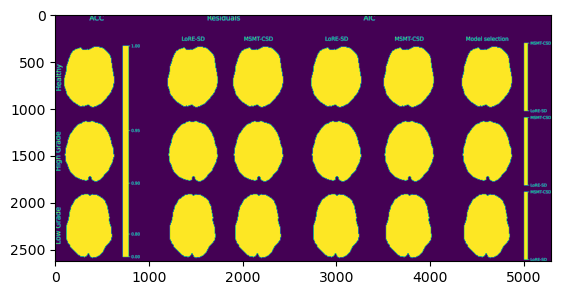

In [61]:
input_paths = [f'cropped_images/in_vivo_{img}' for img in ['ACC.png', 'data_loss.png', 'aic.png', 'model_selection.png']]
output_path = 'images/in_vivo.png'
utils.concat_images_horizontally(input_paths, output_path, pad=300)
trimmed_concat = trim(PIL.Image.open('images/in_vivo.png'))
if trimmed_concat.mode == 'RGBA':
    print('RGBA')
    # Get the data of the image
    data = np.asarray(trimmed_concat.getdata()).reshape((trimmed_concat.height, trimmed_concat.width, 4)).astype(np.uint8)
    data[...,-1] = np.where(data[...,-1] != 0, 255, data[...,-1])

    flat_data = data.reshape(-1, 4).tolist()
    flat_data = [tuple(pixel) for pixel in flat_data]

    plt.imshow(data[:,:,-1])

    # Update the image data
    trimmed_concat.putdata(flat_data)

    # Save or display the updated image
    trimmed_concat.save('images/in_vivo.png')
else:
    trimmed_concat.save('images/in_vivo.png')
# plt.imshow(PIL.Image.open('images/in_vivo.png'))

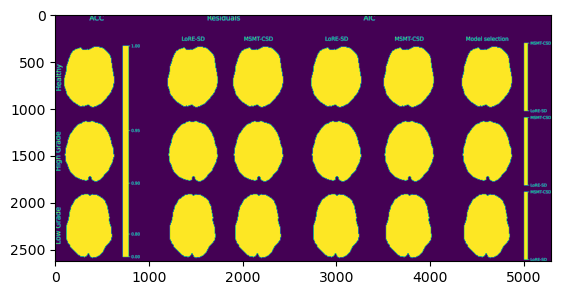

In [18]:
from PIL import Image

# Load the image
image_path = 'images/in_vivo.png'
image = Image.open(image_path)

# Ensure the image has an alpha channel
if image.mode == 'RGBA':
    # Separate the alpha channel
    alpha_channel = image.split()[-1]

    # Display the alpha channel
    plt.imshow(alpha_channel)
else:
    print("The image does not have an alpha channel.")

In [19]:
raise Exception

Exception: 

In [ ]:
def aic(k, target, pred, mask, subtract_mean=False):
    n = target.shape[-1]
    sigma_sq = RSS(target, pred, mask, subtract_mean) / n
    out = 2 * k + n * np.log(sigma_sq)
    out[~mask] = 0
    return out


def RSS(target, pred, mask, subtract_mean=False):
    residual = target - pred
    if subtract_mean:
        residual -= np.mean(residual, axis=-1)

    out = np.sum(residual ** 2, axis=-1)

    out[~mask] = 0
    return out


def get_prob_bsd(aic_bsd, aic_csd):
    p_bsd_over_csd = np.exp((aic_csd - aic_bsd) / 2)
    return p_bsd_over_csd / (1 + p_bsd_over_csd)

In [ ]:
def regrid_5tt(preproc_path):
    path_5tt = os.path.join(preproc_path, '5ttseg.nii.gz')
    path_template = os.path.join(preproc_path, 'residual.mif')
    path_out = os.path.join(preproc_path, '5tt_regrid.mif')
    cmd = f'mrgrid {path_5tt} regrid -template {path_template} {path_out} -force'
    subprocess.run(cmd.split(' '))

In [ ]:
columns = ['Grade', 'ACC', 'Healthy Tissue', 'Low Grade Glioma', 'High Grade Glioma']
lst = []
for dataset in datasets:

    subject  = dataset.split('/')[-1]

    print(f'Processing {subject}')

    grade = brain_slices[subject][1]

    acc = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'acc.mif')).data
    bd_res = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'residual.mif')).data
    csd_res = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/residual.mif')).data
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5
    try:
        load_mrtrix(os.path.join(PREPROC_DIR, subject, '5tt_regrid.mif')).data[...,2] > .95
    except FileNotFoundError:
        regrid_5tt(os.path.join(PREPROC_DIR, subject))
    wm_mask = load_mrtrix(os.path.join(PREPROC_DIR, subject, '5tt_regrid.mif')).data[...,2] > .95

    if 'glioma' in dataset:
        lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)
        lesion = np.logical_and(lesion_mask, mask)

        healthy_mask = np.logical_and(mask, ~lesion)
        res_healthy_bd = bd_res[healthy_mask].mean()
        res_healthy_csd = csd_res[healthy_mask].mean()
        res_tumour_bd = bd_res[lesion].mean()
        res_tumour_csd = csd_res[lesion].mean()

        reduced_data_loss_healthy = res_healthy_bd.mean() / res_healthy_csd.mean()
        if grade == 'Low Grade':
            reduced_data_loss_low_grade = res_tumour_bd.mean() / res_tumour_csd.mean()
            reduced_data_loss_high_grade = None
        else:
            reduced_data_loss_high_grade = res_tumour_bd.mean() / res_tumour_csd.mean()
            reduced_data_loss_low_grade = None

    else:
        reduced_data_loss_healthy = bd_res[mask].mean() / csd_res[mask].mean()
        reduced_data_loss_low_grade = None
        reduced_data_loss_high_grade = None

    lst.append([grade, acc[wm_mask].mean(), reduced_data_loss_healthy, reduced_data_loss_low_grade, reduced_data_loss_high_grade])

df = pd.DataFrame(columns=columns, data=lst)

In [ ]:
columns = ['Grade', 'LoRE-SD: Healthy', 'MSMT-CSD: Healthy', 'LoRE-SD: Glioma', 'MSMT-CSD: Glioma', 'Healthy Tissue', 'Glioma Tissue']
lst = []

k_csd = 45+1+1
k_lore = 45+55

for dataset in datasets:

    subject  = dataset.split('/')[-1]


    print(f'Processing {subject}...')

    target = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'normed.mif')).data
    pred_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'predicted_signal.mif')).data
    pred_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/predicted_signal.mif')).data
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5

    print('    Done loading data')

    aic_lore = aic(k_lore, target, pred_lore, mask, subtract_mean=False)
    aic_csd = aic(k_csd, target, pred_csd, mask, subtract_mean=False)

    print('    Done calculating AIC')

    prob_lore = get_prob_bsd(aic_lore, aic_csd)

    grade = brain_slices[subject][1]



    if 'glioma' in dataset:
        lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)
        lesion = np.logical_and(lesion_mask, mask)

        healthy_mask = np.logical_and(mask, ~lesion)

        aic_lore_healthy = aic_lore[healthy_mask].mean()
        aic_csd_healthy = aic_csd[healthy_mask].mean()
        aic_lore_glioma = aic_lore[lesion].mean()
        aic_csd_glioma = aic_csd[lesion].mean()
        prob_lore_healthy = prob_lore[healthy_mask].mean()
        prob_lore_glioma = prob_lore[lesion].mean()

    else:
        aic_lore_healthy = aic_lore[mask].mean()
        aic_csd_healthy = aic_csd[mask].mean()
        aic_lore_glioma = None
        aic_csd_glioma = None
        prob_lore_healthy = prob_lore[mask].mean()
        prob_lore_glioma = None

    lst.append([grade, aic_lore_healthy, aic_csd_healthy, aic_lore_glioma, aic_csd_glioma, prob_lore_healthy, prob_lore_glioma])

df = pd.DataFrame(columns=columns, data=lst)

In [ ]:
columns = ['Grade', 'LoRE-SD: Healthy', 'MSMT-CSD: Healthy', 'LoRE-SD: Glioma', 'MSMT-CSD: Glioma', 'Healthy Tissue', 'Glioma Tissue']
lst = []

k_csd = 45+1+1
k_lore = 45+55

# for dataset in datasets:
dataset = '/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT010'
subject  = dataset.split('/')[-1]


print(f'Processing {subject}...')

target = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'normed.mif')).data
pred_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'predicted_signal.mif')).data
pred_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/predicted_signal.mif')).data
mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5
lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)
lesion = np.logical_and(lesion_mask, mask)

healthy_mask = np.logical_and(mask, ~lesion)

print('    Done loading data')

aic_lore = aic(k_lore, target, pred_lore, mask, subtract_mean=False)
aic_csd = aic(k_csd, target, pred_csd, mask, subtract_mean=False)

print('    Done calculating AIC')

prob_lore = get_prob_bsd(aic_lore, aic_csd)

print('    Done calculating probability')

In [ ]:
# columns = ['Grade', 'LoRE-SD: Healthy', 'MSMT-CSD: Healthy', 'LoRE-SD: Glioma', 'MSMT-CSD: Glioma', 'Healthy Tissue', 'Glioma Tissue']

prob_healthy = []
prob_low = []
prob_high = []

k_csd = 45+1+1
k_lore = 45+55

for dataset in datasets:

    subject  = dataset.split('/')[-1]


    print(f'Processing {subject}...')

    target = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'normed.mif')).data
    pred_lore = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'predicted_signal.mif')).data
    pred_csd = load_mrtrix(os.path.join(PREPROC_DIR, subject, 'MT-CSD/predicted_signal.mif')).data
    mask = load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5

    print('    Done loading data')

    aic_lore = aic(k_lore, target, pred_lore, mask, subtract_mean=False)
    aic_csd = aic(k_csd, target, pred_csd, mask, subtract_mean=False)

    print('    Done calculating AIC')

    prob_lore = get_prob_bsd(aic_lore, aic_csd)

    grade = brain_slices[subject][1]



    if 'glioma' in dataset:
        lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)
        lesion = np.logical_and(lesion_mask, mask)

        healthy_mask = np.logical_and(mask, ~lesion)

        prob_healthy += list(prob_lore[healthy_mask])

        if grade == 'Low Grade':
            prob_low += list(prob_lore[lesion])
        else:
            prob_high += list(prob_lore[lesion])

    else:
        prob_healthy += list(prob_lore[mask])

In [ ]:
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(ncols=1, nrows=2)
ax_lore = fig.add_subplot(gs[0, 0])
ax_csd = fig.add_subplot(gs[1, 0])

slice_idx = brain_slices[dataset.split('/')[-1]][0]

mask_clip = clip(mask, mask)[...,slice_idx]
aic_lore_clip = clip(aic_lore, mask)[...,slice_idx]
aic_csd_clip = clip(aic_csd, mask)[...,slice_idx]

vmin = np.min([aic_lore_clip[mask_clip], aic_csd_clip[mask_clip]])
vmax = np.max([aic_lore_clip[mask_clip], aic_csd_clip[mask_clip]])

aic_lore_clip = np.ma.masked_where(aic_lore_clip == 0, aic_lore_clip)
aic_csd_clip = np.ma.masked_where(aic_csd_clip == 0, aic_csd_clip)

im_lore = ax_lore.imshow(np.rot90(aic_lore_clip), interpolation=None, cmap='gray', vmin=vmin, vmax=vmax)
im_csd = ax_csd.imshow(np.rot90(aic_csd_clip), interpolation=None, cmap='gray', vmin=vmin, vmax=vmax)

lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)[:, :, slice_idx]
lesion_edge = clip(mask2edge(lesion_mask), mask)

ax_lore.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')
ax_csd.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')

clean_axis(ax_lore)
clean_axis(ax_csd)

plt.subplots_adjust(bottom=0.1, right=0.8, top=.9)
cax = plt.axes([0.65, 0.1, 0.075, 0.8])
plt.colorbar(im_lore, cax=cax)

ax_lore.set_title(r'$AIC_{LoRE-SD}$')
ax_csd.set_title(r'$AIC_{MSMT-CSD}$')

plt.savefig('images/AIC_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

In [ ]:
raise Exception

In [ ]:
df_all_data = pd.DataFrame(
    columns=['Dataset', 'Grade', 'WM ACC', 'AIC Tumour BSD', 'AIC Tumour MSMT-CSD', 'AIC Healthy BSD', 'AIC Healthy MSMT-CSD',
             'Probability of BSD Healthy', 'Probability of BSD Tumour', 'Residual Healthy BD', 'Residual Healthy CSD',
             'Residual Tumour BD', 'Residual Tumour CSD'], data=lst)
df_all_data.set_index('Dataset', inplace=True)
pd.options.display.float_format = "{:,.2f}".format


In [ ]:
df_all_data['Tumour Increase BSD'] = 100 * (df_all_data['Residual Tumour BD'] - df_all_data['Residual Healthy BD']) / \
                                     df_all_data['Residual Healthy BD']
df_all_data['Tumour Increase MSMT-CSD'] = 100 * (
            df_all_data['Residual Tumour CSD'] - df_all_data['Residual Healthy CSD']) / df_all_data[
                                              'Residual Healthy CSD']

df_all_data['Healthy Increase BSD -> MSMT-CSD'] = 100 * (
            df_all_data['Residual Healthy CSD'] - df_all_data['Residual Healthy BD']) / df_all_data[
                                                      'Residual Healthy BD']
df_all_data['Tumour Increase BSD -> MSMT-CSD'] = 100 * (
            df_all_data['Residual Tumour CSD'] - df_all_data['Residual Tumour BD']) / df_all_data['Residual Tumour BD']
healthy_data = df_all_data[df_all_data.loc[:, 'Grade'] == 'Healthy']
low_grade_data = df_all_data[df_all_data.loc[:, 'Grade'] == 'Low Grade']
high_grade_data = df_all_data[df_all_data.loc[:, 'Grade'] == 'High Grade']


In [ ]:
df_all_data['WM ACC']

In [ ]:
lst = []
for df, grade in zip([healthy_data, low_grade_data, high_grade_data], ['Healthy', 'Low Grade', 'High Grade']):
    lst.append([grade, len(df.index),
                df['Healthy Increase BSD -> MSMT-CSD'].mean(), df['Tumour Increase BSD -> MSMT-CSD'].mean(),
                df['Tumour Increase BSD'].mean(), df['Tumour Increase MSMT-CSD'].mean()])
grade_df = pd.DataFrame(columns=['Grade', 'Num', 'Healthy Increase BSD -> MSMT-CSD',
                                 'Tumour Increase BSD -> MSMT-CSD', 'Tumour Increase BSD', 'Tumour Increase MSMT-CSD'],
                        data=lst)
grade_df.set_index('Grade', inplace=True)

In [ ]:
grade_df

In [ ]:
healthy_increase = grade_df.loc[:, ['Num', 'Tumour Increase BSD -> MSMT-CSD']]
healthy_increase['CSD-> BSD'] = 1 - 1 / (1+healthy_increase['Tumour Increase BSD -> MSMT-CSD']/100)
print(healthy_increase)

In [ ]:
import matplotlib

matplotlib.scale.get_scale_names()
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, ListedColormap, AsinhNorm, LogNorm

fig = plt.figure(figsize=(6, 30))
titles = datasets

gs1 = fig.add_gridspec(ncols=2, nrows=len(datasets), hspace=0.1, wspace=-0.4, right=.66)
gs2 = fig.add_gridspec(ncols=1, nrows=len(datasets), hspace=0.1, left=.66)

my_cmap = plt.cm.RdBu(np.arange(plt.cm.RdBu.N))
my_cmap[:, 0:3] *= .8
my_cmap = ListedColormap(my_cmap)

for i, dataset in enumerate(sorted(datasets)):
    ax1 = fig.add_subplot(gs1[i, 0])
    ax2 = fig.add_subplot(gs1[i, 1])
    ax3 = fig.add_subplot(gs2[i, 0])

    subject = dataset.split('/')[-1]

    brain_slice, title = brain_slices[subject]

    aic_bd = np.squeeze(load_mrtrix(os.path.join(SAVE_DIR, subject, 'aic_bd.mif')).data[..., brain_slice:brain_slice + 1])
    aic_csd = np.squeeze(load_mrtrix(os.path.join(SAVE_DIR, subject, 'aic_csd.mif')).data[..., brain_slice:brain_slice + 1])
    mask = np.squeeze((load_mrtrix(os.path.join(dataset, 'PREPROC/mask.mif')).data > .5)[..., brain_slice:brain_slice + 1])

    clipped_aic_bd = pad_to_shape(clip(aic_bd, mask), out_shape)
    clipped_aic_csd = pad_to_shape(clip(aic_csd, mask), out_shape)
    clipped_mask = pad_to_shape(clip(mask, mask), out_shape)

    clipped_aic_bd = np.ma.masked_where(clipped_aic_bd == 0, clipped_aic_bd)
    clipped_aic_csd = np.ma.masked_where(clipped_aic_csd == 0, clipped_aic_csd)

    p_bsd = get_prob_bsd(clipped_aic_bd, clipped_aic_csd)

    fontsize = 8
    ticksize = 5

    if i == 0:
        ax1.set_title('AIC BSD', fontsize=fontsize, weight='bold')
        ax2.set_title('AIC MSMT-CSD', fontsize=fontsize, weight='bold')
        ax3.set_title(r'$P_{BSD}$', fontsize=fontsize + 3, weight='bold')

    ax1.set_ylabel(f'{subject}', fontsize=fontsize, weight='bold')

    vmin = min(np.min(clipped_aic_bd[clipped_mask]), np.min(clipped_aic_csd[clipped_mask]))
    vmax = max(np.max(clipped_aic_bd[clipped_mask]), np.max(clipped_aic_csd[clipped_mask]))

    im1 = ax1.imshow(np.rot90(clipped_aic_bd), vmin=vmin, vmax=vmax, interpolation=None, cmap='gray')
    im2 = ax2.imshow(np.rot90(clipped_aic_csd), vmin=vmin, vmax=vmax, interpolation=None, cmap='gray')
    im3 = ax3.imshow(np.rot90(p_bsd), interpolation=None, cmap='gray')

    for j, (im, ax) in enumerate(zip([im1, im2, im3], [ax1, ax2, ax3])):
        clean_axis(ax)
        if j == 0:
            add_colorbar(im, ax, 5, visible=False)
        elif 1 <= j <= 2:
            add_colorbar(im, ax, 5)
        else:
            add_colorbar(im, ax, 5)

    if 'glioma' in dataset:
        # if not os.path.exists(os.path.join(dataset, 'LESION/lesion_regrid.mif')):
        #     regrid_lesion(data_dir + 'normed.mif', data_dir + 'lesion_mask.mif', data_dir + 'lesion_regrid.mif')
        lesion_mask = (load_mrtrix(os.path.join(dataset, 'LESION/lesion_regrid.mif')).data > .5)[:, :, brain_slice]
        lesion_edge = pad_to_shape(clip(mask2edge(lesion_mask), mask), out_shape)

        ax1.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')
        ax2.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')
        ax3.imshow(np.rot90(lesion_edge), alpha=np.clip(np.rot90(lesion_edge), a_min=0, a_max=1), cmap='winter')

plt.savefig('images/in_vivo_aic.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
# data_dir = f'/usr/local/micapollo01/MIC/DATA/STAFF/sleyse4/data/glioma/sub-PT012/'
# lesion_mask = (load_mrtrix(data_dir + 'lesion_regrid.mif').data > .5)
# print(lesion_mask.shape)
# lesion_edge = mask2edge(lesion_mask)
# save_mrtrix('/LOCALDATA/sleyse4/glioma/sub-PT012/lesion_edge.mif', Image(data=lesion_edge, vox = load_mrtrix(data_dir + 'lesion_regrid.mif').vox))